In [307]:
import sys
sys.path.append('../')
from src import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
%matplotlib inline

Snippet to fit a model on a graph generated on the fly.

First, we generate a graph and the accompanying choice sets. In this case, we set $p=0.25$.

In [26]:
# generate a growing graph
(G, el) = network_generation.generate_mixed_model('test', n_max=20000, r=1.00, p=0.25, grow=True, m=4, vvv=1)
# compute choice sets
D = network_stats.choice_data('test', el, n_alt=8, vvv=1)

[test] generated a growing graph with 5004 nodes and 20001 edges (r=1.00, p=0.25)
[test] final graph has 5004 nodes and 20001 edges


Then, we try fitting a few different models.

## 1) Log Logit

In [3]:
# fit single log model
m1 = logit_individual.LogDegreeModel('test', D=D, vvv=2)
m1.fit()

[test] fitting with BFGS
[test] i=  0 ll=43945.18286
[test] parameters after fitting: [0.27484116]


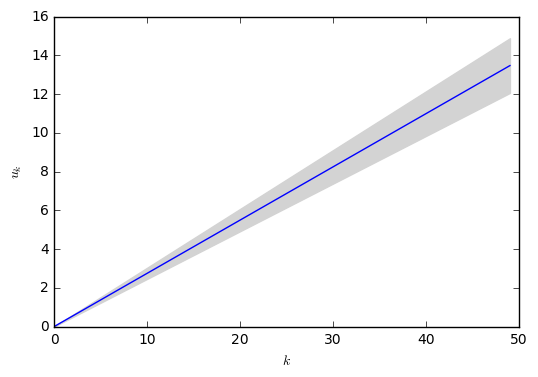

In [4]:
plt.figure()
xs = np.arange(50)
plt.fill_between(xs, xs * (m1.u - 1.96*m1.se), xs * (m1.u + 1.96*m1.se), color='lightgrey')
plt.plot(xs, xs * m1.u, '-b')
plt.xlabel(r"$k$")
plt.ylabel(r"$u_k$")

## 2) Degree Logit

In [5]:
# fit degree logit model
m2 = logit_individual.DegreeModel('test', D=D, vvv=2)
m2.fit()

[test] fitting with BFGS
[test] i=  0 ll=43826.10979
[test] i= 10 ll=43747.39013
[test] i= 20 ll=43738.43618
[test] i= 30 ll=43735.67776
[test] i= 40 ll=43735.47966
[test] i= 50 ll=43735.47943
[test] parameters after fitting: [1.         1.         0.41777652 1.88243385 0.45835985 0.50658657
 0.57074214 0.5688036  0.5960852  0.63282388 0.71623971 0.76042918
 0.73808792 0.76630077 0.77537738 0.93305778 0.88046373 0.81319014
 0.74974491 0.89872139 0.8613798  0.77208867 0.83499446 1.22390291
 0.76401985 1.30692439 1.0351824  1.1874997  0.92805813 1.11494596
 0.92813494 1.04220454 0.76654822 1.0155955  1.21814357 0.87148026
 1.36700307 1.04008241 0.89514831 1.41898992 1.29378986 0.68221412
 1.1846201  1.34665235 1.53580002 1.84975223 0.28011505 2.00750871
 1.30288824 1.30253973 1.95656809]


(0, 6)

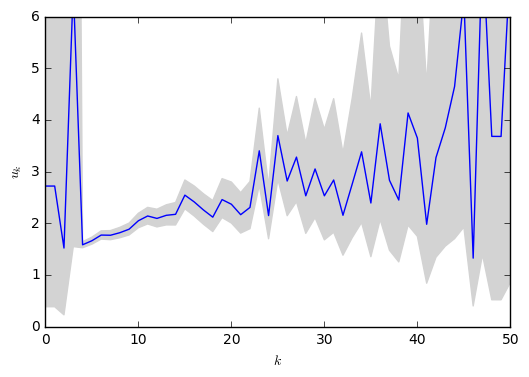

In [11]:
plt.figure()
xs = np.arange(51)
plt.fill_between(xs, np.exp(m2.u - 1.96*m2.se), np.exp(m2.u + 1.96*m2.se), color='lightgrey')
plt.plot(xs, np.exp(m2.u), '-b')
plt.xlabel(r"$k$")
plt.ylabel(r"$u_k$")
axes = plt.gca()
axes.set_ylim([0, 6])

The fit isn't great as there isn't much data in the higher degree region.

## 3) Mixed Logit

In [7]:
# fit mixed logit model
m3 = logit.MixedLogitModel('test', grouped=False, D=D, vvv=1)
m3.add_log_degree_model()
m3.add_uniform_degree_model()
T3 = m3.fit(etol=0.025, n_rounds=50, return_stats=True)

[test] [  0/ 50] (ld) pi_1=0.486 u_1=0.76 ll_1=20695.71 (ud) pi_2=0.514 u_2=1.00 ll_2=22570.85 (*) tot_ll=43266.5613
[test] [ 10/ 50] (ld) pi_1=0.478 u_1=0.56 ll_1=20638.39 (ud) pi_2=0.522 u_2=1.00 ll_2=22940.33 (*) tot_ll=43578.7217
[test] delta in ll (0.000) < etol (0.025), stopping
[test] u's  = [(ld:0.560), (ud:1.000)]
[test] pi's = [(ld:0.478), (ud:0.522)]


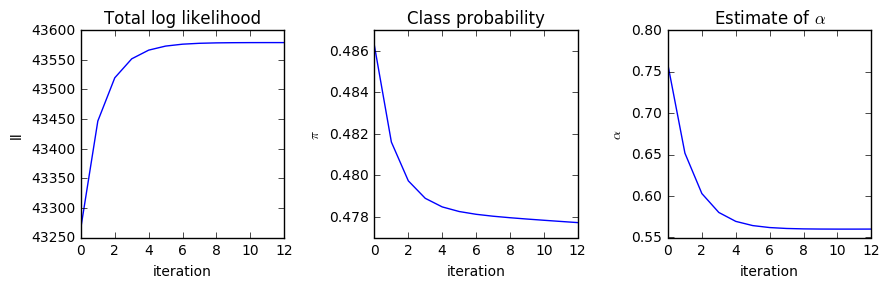

In [8]:
plt.figure(figsize=(9,3))

plt.subplot(131)
T3.tot_ll.plot()
plt.title('Total log likelihood')
plt.xlabel("iteration")
plt.ylabel("ll")

plt.subplot(132)
T3.p1.plot()
plt.title('Class probability')
plt.xlabel("iteration")
plt.ylabel(r"$\pi$")

plt.subplot(133)
T3.u1.plot()
plt.title(r'Estimate of $\alpha$')
plt.xlabel("iteration")
plt.ylabel(r"$\alpha$")

plt.tight_layout()

* It converges quite quickly with respect to total log likelihood.
* The class probability doesn't change at all, and stays at 0.48.
* The estimate for $\alpha$ stops at 0.6.

## 3b) Mixed Logit with clamped coefficients

Here, we 'clamp' the $\alpha$ coefficient. We set it to 1 (pure PA) and do not update it in between iterations of EM. All that changes is the class probabilities.

In [9]:
# fit mixed logit model
m3b = logit.MixedLogitModel('test', grouped=False, D=D, vvv=1)
m3b.add_log_degree_model(bounds=((1, 1),))  # clamped at 1 (full PA)
m3b.add_uniform_degree_model()
T3b = m3b.fit(etol=0.025, n_rounds=200, return_stats=True)

[test] [  0/200] (ld) pi_1=0.486 u_1=1.00 ll_1=20766.01 (ud) pi_2=0.514 u_2=1.00 ll_2=22570.85 (*) tot_ll=43336.8627
[test] [ 10/200] (ld) pi_1=0.386 u_1=1.00 ll_1=16273.90 (ud) pi_2=0.614 u_2=1.00 ll_2=26991.46 (*) tot_ll=43265.3623
[test] [ 20/200] (ld) pi_1=0.331 u_1=1.00 ll_1=13873.87 (ud) pi_2=0.669 u_2=1.00 ll_2=29391.85 (*) tot_ll=43265.7209
[test] [ 30/200] (ld) pi_1=0.301 u_1=1.00 ll_1=12549.24 (ud) pi_2=0.699 u_2=1.00 ll_2=30729.10 (*) tot_ll=43278.3414
[test] [ 40/200] (ld) pi_1=0.283 u_1=1.00 ll_1=11788.28 (ud) pi_2=0.717 u_2=1.00 ll_2=31501.50 (*) tot_ll=43289.7751
[test] [ 50/200] (ld) pi_1=0.273 u_1=1.00 ll_1=11337.69 (ud) pi_2=0.727 u_2=1.00 ll_2=31960.33 (*) tot_ll=43298.0241
[test] [ 60/200] (ld) pi_1=0.266 u_1=1.00 ll_1=11065.38 (ud) pi_2=0.734 u_2=1.00 ll_2=32238.17 (*) tot_ll=43303.5514
[test] [ 70/200] (ld) pi_1=0.262 u_1=1.00 ll_1=10898.62 (ud) pi_2=0.738 u_2=1.00 ll_2=32408.52 (*) tot_ll=43307.1400
[test] [ 80/200] (ld) pi_1=0.260 u_1=1.00 ll_1=10795.63 (ud) pi_

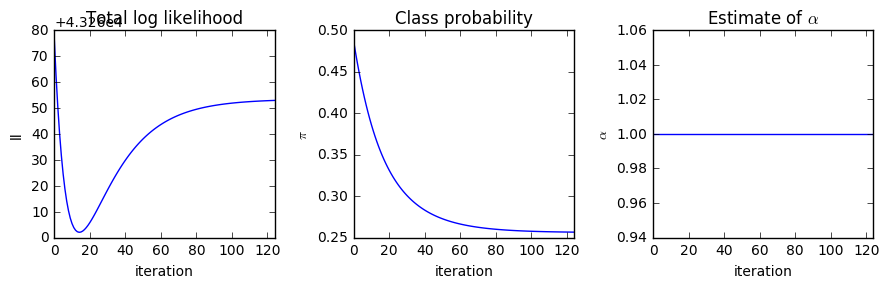

In [10]:
plt.figure(figsize=(9,3))

plt.subplot(131)
T3b.tot_ll.plot()
plt.title('Total log likelihood')
plt.xlabel("iteration")
plt.ylabel("ll")

plt.subplot(132)
T3b.p1.plot()
plt.title('Class probability')
plt.xlabel("iteration")
plt.ylabel(r"$\pi$")

plt.subplot(133)
T3b.u1.plot()
plt.title(r'Estimate of $\alpha$')
plt.xlabel("iteration")
plt.ylabel(r"$\alpha$")

plt.tight_layout()

* The log likelihood is non-monotonic in the first 15 rounds, but then converges (albeit very slowly).
* The class probability converges to 0.277, which is slightly biased, but better than the Log Logit estimate of 0.289.
* $\alpha$ is clamped at 1, so it doesn't change.

## 4) Manual evaluation of the LL function

Here is code tocompute the LL manually for specific values of $\alpha$ (equal to $u$) and $p$ (equal to $\pi$), and to make a surface plot of the resulting values.

In [299]:
from matplotlib import gridspec

def make_z(D, step=0.025):
    alphas = np.arange(0.0, 1.25, step)
    ps = np.arange(0.0, 1.0, step)
    X, Y = np.meshgrid(alphas, ps)
    # apply util.manual_ll to each value of (alpha, p)
    # ideally, we'd use np.vectorize(util.manual_ll, excluded=['D']),
    # but this doesn't seem to work, so on to a more hacky solution
    Z = np.sqrt(X**2 + Y**2)  # to initialize the meshgrid
    scores_uniform = np.array(1.0 / D.groupby('choice_id')['y'].aggregate(len))
    for i in range(len(alphas)):
        alpha = alphas[i]
        D['score'] = np.exp(alpha * np.log(D.deg + util.log_smooth))
        score_tot = D.groupby('choice_id')['score'].aggregate(np.sum)
        scores_pa = np.array(D.loc[D.y == 1, 'score']) / np.array(score_tot)
        for j in range(len(ps)):
            p = ps[j]
            scores = p * scores_pa + (1 - p) * scores_uniform
            Z[j, i] = sum(np.log(scores + util.log_smooth))
            # old: Z[j, i] = util.manual_ll(D, alpha, p)
    return Z

def plot_ll_surface(ax, Z, actual_p, title="Log-likelihood", step=0.025):
    alphas = np.arange(0.0, 1.25, step)
    ps = np.arange(0.0, 1.0, step)
    X, Y = np.meshgrid(alphas, ps)
    i,j = np.unravel_index(Z.argmax(), Z.shape)  # get empirical maximum
    # make the plot
    ax.view_init(elev=40, azim=320)
    ax.dist = 12
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$p$')
    ax.set_zlabel('LL')
    ax.plot([alphas[j]]*2, [ps[i]]*2, ax.get_zlim(), 'black')   # empirical max
    ax.plot([1]*2, [actual_p]*2, ax.get_zlim(), 'green')  # actual
    ax.set_title(title)

def plot_ll_heatmap(ax, Z, actual_p, title="Log-likelihood", step=0.025):
    alphas = np.arange(0.0, 1.25, step)
    ps = np.arange(0.0, 1.0, step)
    X, Y = np.meshgrid(alphas, ps)
    i,j = np.unravel_index(Z.argmax(), Z.shape)  # get empirical maximum
    # make the plot
    ax.imshow(Z, cmap=cm.coolwarm)
    ax.set_xticks(np.arange(0, (1.25/step) + 0.05, (1.25/step)/5))
    ax.set_xticklabels(np.arange(0.0, 1.2505, 0.25))
    ax.set_yticks(np.arange(0,  (1.0/step) + 0.05, (1.00/step)/4))
    ax.set_yticklabels(np.arange(0.0, 1.05, 0.25))
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$p$')
    ax.plot((1.25/step)/5 * 4,
            (1.00/step)/4 * actual_p * (1/0.25),
            'o', color='green')  # actual
    ax.plot(j, i, 'o', color='black')  # empirical max
    ax.set_title(title)

def make_both_plot(Z, actual_p, step=0.025):
    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1]) 
    # make the surface plot
    ax = fig.add_subplot(gs[0], projection='3d')
    plot_ll_surface(ax, Z, 0.25, title=r"LL Surface for ($\alpha$=1, $p$=%.2f)" % 0.25)
    # make heatmap
    ax = fig.add_subplot(gs[1])
    plot_ll_heatmap(ax, Z, 0.25, title=r"LL Surface for ($\alpha$=1, $p$=%.2f)" % 0.25)
    fig.show()
    

First we run it on our running example.
The black dot is the empirical maximum and the green dot represents the actual value.

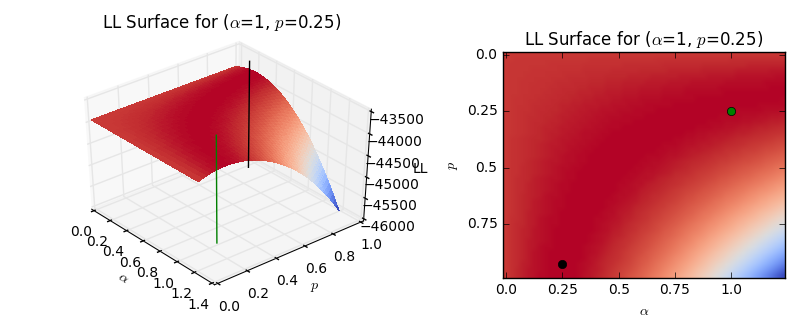

In [300]:
Z = make_z(D)
make_3d_plot(Z, 0.25)

Here is how to do the function call with the EM framework

In [19]:
# fit mixed logit model
m3c = logit.MixedLogitModel('test', grouped=False, D=D, vvv=1)
m3c.add_log_degree_model(bounds=((1, 1),))
m3c.add_uniform_degree_model()
# evaluate LL for u = 1 and alpha = 0.25
m3c.ll_pi({0: [1], 1: [1]}, {0: 0.25, 1: 0.75})

43352.54602569292

Here we run the same code on the graphs we generated before. I show the LL surface for all graphs with $r=1$, with only $p$ varying. In all cases $\alpha=1$. I show the results on both simulated growing and densifying graphs.

Again, the black dot is the empirical maximum and the green dot represents the actual value.

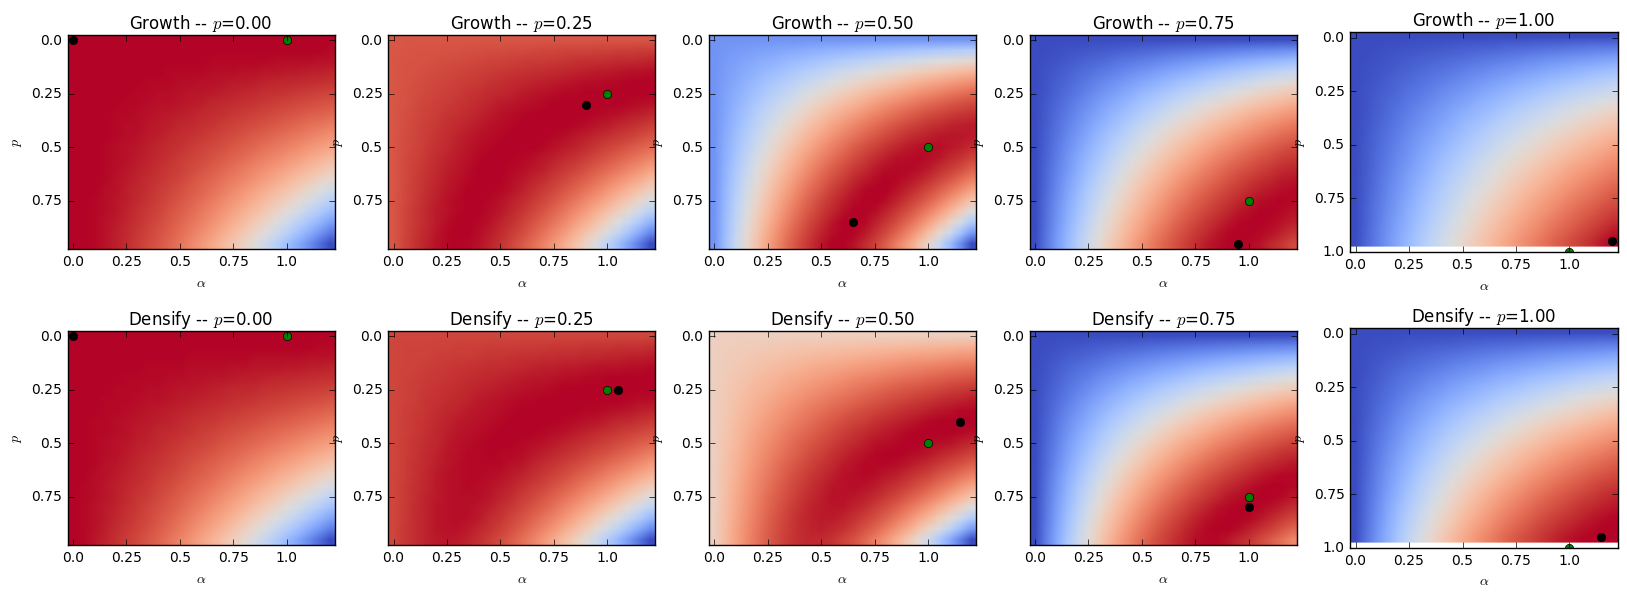

In [311]:
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(2, 5)
i = 0
step = 0.05
for t in ['g','d']:
    for p in [0, 0.25, 0.5, 0.75, 1]:
        Dt = util.read_individual_data_single('%s-1.00-%.2f-00.csv' % (t, p))
        Zt = make_z(Dt, step=step)
        ax = fig.add_subplot(gs[i])
        title = r"%s -- $p$=%.2f" % ("Growth" if t=='g' else "Densify", p)
        plot_ll_heatmap(ax, Zt, p, title=title, step=step)
        i += 1
fig.show()

Here are some observations:
* when $p=0$, any $\alpha$ gives equivalent results. Similarly, if $\alpha=0$, $p$ doesn't matter.
* with a non-trivial $p$, there is an approximate trade-off between $p$ and $\alpha$, where an increase in $p$ gets paired with a decrease in $\alpha$. This leads to large regions with very similar likelihoods, especially for low $p$. 
* For densifying graphs, the empirical maximum is still close to the actual parameter values, but for growing graphs less so. This could be due to the larger number of choices sets with fewer choices and less inequality in the degrees.
* with $p=1$, it looks like $\alpha$ gets overestimated. This happens slightly more so in the growing graphs. I'm not sure why this would be.